<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />
<font size="7"> <b> Calculating HAND from DEM</b></font>

<hr>
<font size="4"> <b> Adapted for Guyana project and running on MPC by André de Oliveira</b> <br>
</font>

<font size="3">
    
This notebook is an adapted version of the Open SAR Lab <cite><a href="https://github.com/andreldeod/opensarlab-notebooks/blob/474bc4c513bea4959cb9c24eca8988658e83a730/SAR_Training/English/HydroSAR/Big_Hand_notebook.ipynb"><i>Big_Hand_notebook</i></a></cite> notebook from the <cite><a href="https://github.com/andreldeod/opensarlab-notebooks/tree/474bc4c513bea4959cb9c24eca8988658e83a730"><i>ASF Jupyter Notebook repo</i></a></cite>. It has been adapted to run inside of Microsoft Planetary Computer (MPC) with our Guyana project data. It can be run locally. 

To run this notebook you must also have the following modules in your notebook directory:
1. pgrid_modified.py (Modified pgrid due to bug in original. Included in this repo)
2. locked_hydrosar_env.yml environment file (Included in this repo.)
3. You will need a Digital Elevation Model (DEM) of your study area. 
4. Finally you will need to set up the environment that the notebook uses in Binder. Here are the steps for that:
       a. Open a Terminal in the Jupyter notebook. 
       b. Open the SetupEnvironment notebook from the repo.
       c. Run each line of code from the SetupEnvironment notebook your terminal.
       d. Return to this notebook and change the Kernel using the Kernel tab at the top left:
           Kernel > Change Kernel > Python[conda env:hydrosar]


<hr>
Notes from original notebook:
<br>
<font size="5">  How to obtain Height Above Nearest Drainage using a BIG Digital Elevation Model with PySheds </font>

<br>
<font size="4"> <b> Part of NASA A.37 Project:</b> Integrating SAR Data for Improved Resilience and Response to Weather-Related Disasters   <br>
<font size="4"> <b> PI:</b>Franz J. Meyer <br>
<font size="3"> Version 0.1.13 - 2022/02/25 <br>
<b>Change Log</b><br>
See bottom of the notebook.<br>
</font> 
<font color='rgba(0,0,200,0.2)'> <b>Contact: </b> batuhan.osmanoglu@nasa.gov </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3"> The first step in any notebook is to import the required Python libraries into the Jupyter environment. In this notebooks we use the following libraries:
<ol type="1">
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm" target="_blank">PyLab</a></b> is a procedural interface to the Matplotlib object-oriented plotting library. Matplotlib is the whole package; matplotlib.pyplot is a module in Matplotlib; and PyLab is a module that gets installed alongside Matplotlib.</li>
    <li> <b><a href="https://github.com/mdbartos/pysheds" target="_blank">PySHEDS</a></b> is a new python module developed by Matt Bartos with the motto "Simple and fast watershed delineation in python." We use the Height Above Nearest Drainage (HAND) implementation in PySHEDS.</li>
    <li> <b><a href="https://github.com/Toblerity/Fiona" target="_blank"> Fiona </a></b> reads and writes geographic data files and thereby helps Python programmers integrate geographic information systems with other computer systems. Fiona contains extension modules that link the Geospatial Data Abstraction Library (GDAL). </li>
    <li> <b><a href="https://github.com/Toblerity/Shapely" target="_blank"> Shapely </a></b>allows for manipulation and analysis of geometric objects in the Cartesian plane. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.</li>
    <li> <b><a href="https://geopandas.org/" target="_blank"> GeoPandas </a></b> is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.</li>
    <li> <b><a href="https://www.astropy.org/" target="_blank"> The Astropy Project </a></b> is a community effort to develop a core package for astronomy using the Python programming language and improve usability, interoperability, and collaboration between astronomy Python packages. The core astropy package contains functionality aimed at professional astronomers and astrophysicists, but may be useful to anyone developing astronomy software.</li>
    <li> <b><a href="https://github.com/tqdm/tqdm" target="_blank"> tqdm </a></b> is a smart progress meter that allows easy addition of a loop counter.</li>

In [1]:
%%capture

!pip install url_widget
!pip install looseversion

In [2]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [3]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
#if env[0] != '/home/jovyan/.local/envs/hydrosar':
if env[0] != '/srv/conda/envs/hydrosar':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "hydrosar" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "hydrosar" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "hydrosar" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

In [4]:
#Setup Environment
from pathlib import Path
from functools import partial
import warnings #Suppress warnings on occasion
import tempfile #for creation of temporary folder
import urllib   #for data download
import zipfile  #zipfile

from ipyfilechooser import FileChooser

import numpy as np
from osgeo import gdal, osr
gdal.UseExceptions()
from osgeo import osr
import matplotlib.pyplot as plt 
import pysheds
#from pysheds.pgrid import Grid as Pgrid
from pgrid_modified import Grid as Pgrid
from affine import Affine
import rasterio
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")#, category=FutureWarning)    
    import pyproj
import fiona
import fiona.crs
import shapely
from shapely.ops import transform
import geopandas as gpd
import astropy
import astropy.convolution
from scipy import ndimage
from tqdm.auto import tqdm

from IPython.core.debugger import set_trace #Enable if you like to debug and add set_trace() where you want debugger

#The two lines below are for visually browsing and selecting the DEM. 
import ipywidgets as ui
from IPython.display import display

#The two lines below are for visually browsing and selecting the DEM. 
from IPython.display import FileLink

<font size="5"> <b> 1. Define convenience functions </b> </font>

<font size="3"> Here we define some functions for later convenience.
    
<ol type="1">
    <li> <b>fiona_read_vectorfile</b> returns a list of shapes (and optionally properties) using fiona. </li>
    <li> <b>fiona_write_vectorfile</b> write a vectorfile containing shapes (and optionally properties) with fiona. </li>
    <li> <b>intersect</b> returns polygons from multiple 'geometries' read by fiona.</li>
    <li> <b>reproject</b> reprojects a given vector file to another coordinate reference system (CRS). </li>
    <li> <b>transform_shape</b> transforms a single geometry to another coordinate reference system (CRS).</li>
    <li> <b>xy2coord</b> converts pixel index to position based on geotransform. </li>     
    <li> <b>get_projection</b> returns the spatial reference system in wkt, proj4, or epsg formats.</li>
    <li> <b>gdal_get_geotransform</b> returns the geotransform of the dataset using GDAL. </li>
    <li> <b>gdal_get_size</b> returns width and height for a given raster file. </li>
    <li> <b>gdal_bounding_box</b> returns the bounding box in geocoded coordinates for a given raster file. </li>    
    <li> <b>gdal_write</b> is used to export the generated HAND product using GDAL. </li>
    <li> <b>fill_nan_based_on_DEM</b> is used to fill small not-a-number areas in final HAND product if necessary. </li>
    <li> <b>calculate_hand</b> returns the height above nearest drainage for a given DEM using the pySheds library. </li>
    

In [5]:
# Define convenience functions
def fiona_read_vectorfile(vectorfile, get_property=None):
    """shapes=fiona_read_vectorfile(vectorfile, get_property=None)
       shapes, props=fiona_read_vectorfile(vectorfile, get_property='Property_Name')
       Returns a list of shapes (and optionally properties) using fiona.
       
       vectorfile: any fiona compatible vector file. 
       get_property: String for the property to be read. 
       shapes: List of vector "geometry"
       props:  List of vector "properties"
    """
    with fiona.open(vectorfile, "r") as shpf:
        shapes   = [ feature["geometry"] for feature in shpf ]
        print(f"Number of shapes loaded: {len(shapes)}")
        if get_property is not None:
            props = [ feature["properties"][get_property] for feature in shpf ]
            return shapes, props
        else:
            return shapes    

def fiona_write_vectorfile(shapes, vectorfile, crs=fiona.crs.from_epsg(4326), driver='ESRI Shapefile', schema_type='Polygon'):
    if schema_type=='Polygon':
        schema={'geometry': 'Polygon',
                'properties': {}}        
    with fiona.open(vectorfile, 'w',crs=crs,driver=driver, schema=schema) as output:
        for s in shapes:
            if schema_type=='Polygon':
                sp= shapely.geometry.Polygon(s)
            output.write({'geometry':shapely.geometry.mapping(sp),'properties': {}})    
        
def intersect(shapes, polygon, properties=None):
    """
    polygons=intersect(shapes, polygon, properties=None)
    Returns polygons from multiple 'geometries' read by fiona.
    
    shapes: shapes returned by fiona_read_vectorfile()
    polygon: a single polygon to intersect with shapes
    properties: If not none, returns the property value instead of polygon geometry.
    """
    #first loop to split multi polygons to single polygons
    polygons=[]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")    
        for k,shape in enumerate(tqdm(shapes)):
            if shape['type']=='MultiPolygon':
                for l,p in enumerate(shape['coordinates']):
                    s=shapely.geometry.Polygon(p[0])
                    if polygon.intersects(s) and properties is None:            
                        polygons.append(s)
                    elif polygon.intersects(s) and properties is not None:
                        if np.isscalar(properties[k]):
                            polygons.append(properties[k])
                        else:
                            polygons.append(properties[k][l])
                    
            elif shape['type']=='Polygon':
                s=shapely.geometry.Polygon(shape['coordinates'][0])
                if polygon.intersects(s) and properties is None:
                    polygons.append(s)
                elif polygon.intersects(s) and properties is not None:
                    polygons.append(properties[k])
    return polygons

def reproject(vector_file, output_crs, output_file=None):
    """
    output_file=reproject(vector_file, output_crs, output_file=None)
    Reprojects a given vector file to another reference frame (CRS). 
    vector_file: Any vector file that can be opened with GeoPandas
    output_crs: A rasterio opened crs (e.g. dem.crs)
    output_file: if not defined, defaults to vector_file[:-4]+'_warp.shp'. 
    """
    v=gpd.GeoDataFrame.from_file(vector_file)
    warp=v.to_crs(output_crs)
    if output_file is None:
        output_file=vector_file[:-4]+'_warp.shp'
    warp.to_file(output_file)
    return output_file

def transform_polygon(polygon, s_srs='EPSG:4269', t_srs='EPSG:4326'):
    shp_geom = shapely.geometry.Polygon(polygon)    
    project = pyproj.Transformer.from_proj(
        pyproj.Proj(init=s_srs), # source coordinate system
        pyproj.Proj(init=t_srs)) # destination coordinate system
    
    # polygon is a shapley Polygon
    return transform(project.transform, shp_geom)  # apply projection

def transform_shape(shape, s_srs='epsg:4326', t_srs='epsg:4326'):
    transformation=partial(
               pyproj.transform,
               pyproj.Proj(init=s_srs), #source coordinate system
               pyproj.Proj(init=t_srs)) #destination coordinate system
    return shapely.ops.transform(transformation, shape)

def xy2coord(x,y,gT):
    '''
    lon,lat=xy2coord(x,y,geoTransform)
    converts pixel index to position based on geotransform.
    '''
    coord_x=gT[0] + x*gT[1] + y*gT[2]
    coord_y=gT[3] + x*gT[4] + y*gT[5]
    return coord_x, coord_y

def get_projection(filename, out_format='proj4'):
    """
    epsg_string=get_epsg(filename, out_format='proj4')
    """
    try:
      ds=gdal.Open(filename, gdal.GA_ReadOnly)
      srs=gdal.osr.SpatialReference()
      srs.ImportFromWkt(ds.GetProjectionRef())
    except: #I am not sure if this is working for datasets without a layer. The first try block should work mostly.
      ds=gdal.Open(filename, gdal.GA_ReadOnly)
      ly=ds.GetLayer()
      if ly is None:
        print(f"Can not read projection from file:{filename}")
        return None
      else:
        srs=ly.GetSpatialRef()
    if out_format.lower()=='proj4':
      return srs.ExportToProj4()
    elif out_format.lower()=='wkt':
      return srs.ExportToWkt()
    elif out_format.lower()=='epsg':
      crs=pyproj.crs.CRS.from_proj4(srs.ExportToProj4())
      return crs.to_epsg()

def gdal_get_geotransform(filename):
    '''
    [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]=gdal_get_geotransform('/path/to/file')
    '''
    #http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    ds = gdal.Open(filename)
    return ds.GetGeoTransform()

def gdal_get_size(filename):
    """(width, height) = get_size(filename)
    """
    ds = gdal.Open(filename)
    width = ds.RasterXSize
    height = ds.RasterYSize
    ds=None
    return (width, height)

def gdal_bounding_box(filename):
    """
    ((lon1,lat1), (lon2,lat2), (lon3,lat3), (lon4,lat4))=bounding_box('/path/to/file')
    """
    gT=gdal_get_geotransform(filename)
    width, height=gdal_get_size(filename)     
    return (xy2coord(0,0,gT), xy2coord(width,0,gT), xy2coord(width, height,gT), xy2coord(0, height,gT))

def gdal_write(ary, geoTransform, fileformat="GTiff", filename='jupyter_rocks.tif', data_format=gdal.GDT_Float64, nodata=None, srs_proj4='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', options = ["TILED=YES","COMPRESS=LZW","INTERLEAVE=BAND","BIGTIFF=YES"], build_overviews=True):
    '''gdal_write(ary, geoTransform, format="GTiff", filename='jupyter_rocks.tif', data_format=gdal.GDT_Float64 nodata=None, srs_proj4='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    ary: 2D array.
    geoTransform: [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]
    format: "GTiff"     
    '''           
    if ary.ndim ==2:
      Ny, Nx = ary.shape
      Nb = 1;
    elif ary.ndim==3:
      Ny,Nx,Nb=ary.shape
    else: 
      print("Input array has to be 2D or 3D.")
      return None
    
    driver = gdal.GetDriverByName(fileformat)
    ds = driver.Create(filename, Nx, Ny, Nb, data_format, options)

    #ds.SetGeoTransform( ... ) # define GeoTransform tuple
    # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
    ds.SetGeoTransform( geoTransform )    
    srs=osr.SpatialReference()
    srs.ImportFromProj4(srs_proj4)
    ds.SetProjection(srs.ExportToWkt() );
    if nodata is not None:
        ds.GetRasterBand(1).SetNoDataValue(0);
    if Nb==1:
      ds.GetRasterBand(1).WriteArray(ary)
    else:
      for b in range(Nb):
        ds.GetRasterBand(b+1).WriteArray(ary[:,:,b])
    if build_overviews:
        ds.BuildOverviews("NEAREST", [2, 4, 8, 16, 32, 64, 128, 256])
    ds = None
    print("File written to: " + filename);

def fill_nan(arr):
    """
    filled_arr=fill_nan(arr)
    Fills Not-a-number values in arr using astropy. 
    """    
    kernel = astropy.convolution.Gaussian2DKernel(x_stddev=3) #kernel x_size=8*stddev
    arr_type=arr.dtype          
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        while np.any(np.isnan(arr)):
            arr = astropy.convolution.interpolate_replace_nans(arr.astype(float), kernel, convolve=astropy.convolution.convolve)
    return arr.astype(arr_type) 

def fill_nan_based_on_DEM(arr, dem):
    """
    filled_arr=fill_nan_based_on_DEM(arr, dem)
    Fills Not-a-number values in arr using astropy. 
    """    
    hond = dem - arr; #height of nearest drainage 
    kernel = astropy.convolution.Gaussian2DKernel(x_stddev=3) #kernel x_size=8*stddev
    arr_type=hond.dtype          
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        while np.any(np.isnan(hond)):
            hond = astropy.convolution.interpolate_replace_nans(hond.astype(float), kernel, convolve=astropy.convolution.convolve)
    my_mask=np.isnan(arr)
    arr[my_mask]=dem[my_mask]-hond[my_mask]
    return arr.astype(arr_type) 

def calculate_hand(dem, dem_gT, dem_proj4, mask=None, verbose=False, acc_thresh=100):
    """
    hand=calculate_hand(dem, dem_gT, dem_proj4, mask=None, verbose=False)
    Calculate the height above nearest drainage using pySHEDS library. This is done over a few steps:

    Fill_Depressions fills depressions in a DEM (regions of cells lower than their surrounding neighbors).
    Resolve_Flats resolves drainable flats in a DEM.
    FlowDir converts the DEM to flow direction based on dirmap.
    Accumulation converts from flow direction to flow accumulation.
    Compute_Hand is used to convert directions to height above nearest drainage.
    
    NaN values are filled at the end of resolve_flats and final steps. 
    
    Inputs:
      dem=Numpy array of Digital Elevation Model (DEM) to convert to HAND. 
      dem_gT= GeoTransform of the input DEM
      dem_proj4=Proj4 string of DEM
      mask=If provided parts of DEM can be masked out. If not entire DEM is evaluated. 
      verbose=If True, provides information about where NaN values are encountered. 
      acc_thresh=Accumulation threshold. By default is set to 100. If none, 
                 mean value of accumulation array (acc.mean()) is used. 
    """

    #Specify  directional mapping
             #N , NE , E ,SE,S,SW, W , NW
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32) 
    #Load DEM into pySheds
    if type(dem_gT)==Affine:
        aff=dem_gT
    else:
        aff=Affine.from_gdal(*tuple(dem_gT))
    if mask is None:
        mask=np.ones(dem.shape, dtype=np.bool)
    grid=Pgrid() #(shape=dem.shape,affine=aff, crs=dem_proj4, mask=mask)
    grid.add_gridded_data(dem, data_name='dem',affine=aff, crs=dem_proj4, mask=mask)        
    #Fill Depressions
    grid.fill_depressions('dem', out_name='flooded_dem')
    if verbose:
        set_trace()
    if np.any(np.isnan(grid.flooded_dem)):
        if verbose:
            print('NaN:fill_depressions')
            grid.flooded_dem=fill_nan(grid.flooded_dem)     
    #Resolve_Flats 
    #Please note that Resolve_Flats currently has an open bug and can fail on occasion. https://github.com/mdbartos/pysheds/issues/118
    try:
        grid.resolve_flats('flooded_dem', out_name='inflated_dem')
    except:
        grid.inflated_dem=grid.flooded_dem
    #if np.sum(np.isnan(grid.inflated_dem))<dem.size*0.5: #if nans account for less than 50% of the dem nanfill. 
    #    if verbose:
    #        print('NaN:resolve_flats but less than 50%. Applying large value')
    #    grid.inflated_dem=fill_nan(grid.inflated_dem)
    if np.any(np.isnan(grid.inflated_dem)):
        if verbose:
            print('NaN:resolve_flats replacing with inflated_dem')
        #grid.inflated_dem=fill_nan(grid.inflated_dem)                    
        grid.inflated_dem[np.isnan(grid.inflated_dem)] = dem[np.isnan(grid.inflated_dem)]#10000  # setting nan to 10.000 to ensure drainage
        ### Ref: https://github.com/mdbartos/pysheds/issues/90
    #Obtain flow direction
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap, apply_mask=True)
    if np.any(np.isnan(grid.dir)):
        if verbose:
            print('NaN:flowdir')
            grid.dir=fill_nan(grid.dir)     
    #Obtain accumulation
    grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')
    if np.any(np.isnan(grid.acc)):
        if verbose:
            print('NaN:accumulation')
            grid.acc=fill_nan(grid.acc)     
    #Generate HAND
    if acc_thresh is None:
        acc_thresh=grid.acc.mean()
    #grid.compute_hand('dir', 'inflated_dem', grid.acc >100, out_name='hand')
    #Copy HAND as an array. 
    #hand=grid.view('hand')    
    hand = grid.compute_hand('dir', 'inflated_dem', grid.acc > acc_thresh, inplace=False)
    if np.any(np.isnan(hand)):
        if verbose:
            print('NaN:compute_hand')
            #attempt to fill low-lying flat areas with zeros. In radar DEMs vegetation alongside river, can trap
            #the river and not let any water go into the river. This was seen in Bangladesh with SRTM 1 arcsec
            #and NASADEM at Hydro Basin with ID: 4120928640
            
            #get nans inside masked area and find mean height for pixels outside the nans (but inside basin mask)
            valid_nanmask=np.logical_and(mask, np.isnan(hand))
            valid_mask   =np.logical_and(mask, ~np.isnan(hand)) 
            mean_height=grid.inflated_dem[valid_mask].mean()
            #calculate gradient and set mean gradient magnitude as threshold for flatness. 
            g0,g1=np.gradient(grid.inflated_dem);
            gMag=np.sqrt(g0**2+g1**2)
            gMagTh=np.min(1, np.mean(gMag*np.isnan(hand)) ) # Make sure this threshold is not too high. We don't want to set rough surfaces to zero.
            
            #define low lying (<mean) pixels inside valid area. 
            #valid_flats=np.logical_and(valid_nanmask, grid.dir==0) #I thought grid.dir=0 meant flats. But this is not the case always apparently. 
            valid_flats=np.logical_and(valid_nanmask, gMag<gMagTh)
            valid_low_flats=np.logical_and(valid_flats, grid.inflated_dem<mean_height)            
            hand[ valid_low_flats ]=0
        if np.any(np.isnan(hand)):
            grid.hand=fill_nan(hand) 
    return hand

def point_coordinates_to_geometry(coordinates, geometry_type='Polygon'):
    if geometry_type.lower() == 'polygon':
      return shapely.geometry.Polygon(coordinates)
    else:
      raise NotImplementedError
def print_duration(start):
    print('   - Processing time: %6.2f minutes' % ((time.time() - start)/60.0))
    print('-----------------------------------------------------------------------------------')
    print(' ')

<font size="5"> <b> 2. Load DEM & Set processing parameters </b> </font>

<font size="3">Load and display the digital elevation model. The DEM can be uploaded using the file Jupyterhub File Browser before selection below. 
<br>

In [23]:
# ANDRÉ ADDED Define the full path to the home directory
home_dir = Path.home()

# Define some processing parameters
version="0.1.13" #used in filenames as a suffix
show_plots=True #set True if you like to see plots providing more information on steps.
temporary_folder_object=tempfile.TemporaryDirectory()
temp_dir = Path(temporary_folder_object.name) #Folder name to be used in generating temporary files
#hybas_dir = Path('~/external_data') # if you do not want to keep any hybas files set it as hybas_dir=temp_dir
# gshhg_dir = Path('~/external_data') #if you do not want to keep the coastline file, set it as gshhg_dir=temp_dir
hybas_dir = home_dir / "external_data" # ADDED
gshhg_dir = home_dir / "external_data" # ADDED
debug=False #If true print more detailed messages. Turn false when using IPDB to debug. Otherwise plots won't be visible within IPDB. 
accumulation_threshold=None # This sets how large of an accumulation area is used for HAND. If too small, we get a very fine river network, which can be noisy. If too high, we get a very smooth HAND... 
                           # Recommended values None (for automatic) or 100. 
pad_width=1 # Padding applied to the hydrobasins polygons for HAND processing. At least 1 pixel is recommended. 
# define URLs for external data used in this project. 
nodata_fill_value=np.finfo(float).eps # If set to None, nodata/ocean values are not touched (likely returning np.nan). If a value is specified, it will be used to fill oceans and no-data areas in input dem. 
dem_nodata_value=0 # If set to None, will read from dem.nodatavals property. If set, uses that value as a mask to skip nan-interpolation 
gshhg_url='http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip'
hybas_extents_url='https://www.dropbox.com/s/fthjqjnxj829d7p/hybas_extent_v1c.gpkg?dl=1'
hybas_links={'af':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABSBGFylsZ9KoG8zYRvOTzqa/HydroBASINS/standard/af/hybas_af_lev12_v1c.zip?dl=1',
             'eu':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AADULrBSkGy5dHOZ8vMxWpWxa/HydroBASINS/standard/eu/hybas_eu_lev12_v1c.zip?dl=1',
             'si':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABtI2KbgItfLp4jmHcvZhDea/HydroBASINS/standard/si/hybas_si_lev12_v1c.zip?dl=1',
             'as':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AADWZKiGaCncO5JdRLmkIduMa/HydroBASINS/standard/as/hybas_as_lev12_v1c.zip?dl=1',
             'au':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AAA5lwuZZ5EZsxrx_EBQGW3ma/HydroBASINS/standard/au/hybas_au_lev12_v1c.zip?dl=1',
             'sa':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABPzWxd07pmshjZl6Y0NPXNa/HydroBASINS/standard/sa/hybas_sa_lev12_v1c.zip?dl=1',
             'na':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AAA1ofV7PhSY_x7vQluubYyNa/HydroBASINS/standard/na/hybas_na_lev12_v1c.zip?dl=1',
             'ar':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AADaA0icxaPYgaQGuLbSaKfna/HydroBASINS/standard/ar/hybas_ar_lev12_v1c.zip?dl=1',
             'gr':'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AACNOTXj-M1T-rpz5k_QJd6Ka/HydroBASINS/standard/gr/hybas_gr_lev12_v1c.zip?dl=1'}
if show_plots:
    %matplotlib widget
    # set to inline to revert back to Jupyter default. 

<br>
<font face="Calibri" size="4"><b>2.1 Select your DEM using the file-tree below:</b> </font>

In [7]:
# Display file selector to select DEM
print("Choose your GDAL compatible DEM using the file browser below:")

#fc = FileChooser('/home/jovyan/notebooks/SAR_Training/English/HydroSAR')
fc = FileChooser('/home/jovyan/GuyanaFlooding/data')
display(fc)

Choose your GDAL compatible DEM using the file browser below:


FileChooser(path='/home/jovyan/GuyanaFlooding/data', filename='', title='', show_hidden=False, select_desc='Se…

<font face="Calibri" size="4"> <b>2.2 Obtain DEM Parameters</b></font>
<br><br>
<font face="Calibri" size="3">We obtain several parameters for the DEM like it's geotransform, projection and bounding box. 

In [8]:
#Obtain DEM parameters like, projection, geoTransform, bounding box etc. 
dem_file = str(Path(fc.selected))

try:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        #load and display dem
        print(f"Selected DEM: {dem_file}")
        dem_gT=gdal_get_geotransform(dem_file)
        dem_proj4=get_projection(dem_file)

        import rasterio.mask
        dem=rasterio.open(dem_file)
        bb=gdal_bounding_box(dem_file)
        bb_poly=list(bb)
        bb_poly.append(bb[0])
        dem_poly=shapely.geometry.Polygon(bb_poly)    
        dem_poly_wgs84=transform_shape(dem_poly, s_srs=dem.crs.to_string())
except:
    # don't go beyond here with Run All if above did not work. 
    print('Please select a GDAL compatible DEM using the file-tree above.')
    assert False

Selected DEM: /home/jovyan/GuyanaFlooding/data/rupununiDEMprj.tif


In [13]:
# CHANGE AOI TO SAME CRS AS DEM
# Load the GeoJSON file into a GeoDataFrame
aoi = gpd.read_file('/home/jovyan/GuyanaFlooding/data/Rupununi_Wetlands.geojson')

# Print the current CRS of the GeoDataFrame
print("Original CRS of the file:", aoi.crs)

# Ensure the current CRS is set if it's missing (assuming it's EPSG 24821 as mentioned)
if not aoi.crs:
    aoi.set_crs('epsg:24821', inplace=True)
    print("CRS was not set. Set to EPSG:24821")

# Reproject the GeoDataFrame to EPSG 32620
aoi = aoi.to_crs(epsg=32620)

# Print the new CRS of the GeoDataFrame
print("New CRS of the file:", aoi.crs)

# Optional: Save the reprojected GeoDataFrame back to a new GeoJSON file
aoi.to_file('/home/jovyan/GuyanaFlooding/data/Rupununi_Wetlands_epsg32620.geojson', driver='GeoJSON')


Original CRS of the file: EPSG:24821
New CRS of the file: EPSG:32620


In [ ]:
# FOR AOI THAT IS BOUNDING BOX OF WETLAND BOUNDARY
# Import necessary libraries
from shapely.geometry import Polygon

# Define the bounding box coordinates
bbox = [-59.846921, 3.315969, -58.981504, 4.028123]  # [min_lon, min_lat, max_lon, max_lat]

# Create a Polygon from the bounding box
# Coordinates need to be in the form [(lon, lat), ...] and must close the polygon (start and end at the same point)
polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1]), (bbox[0], bbox[1])])

# Create a GeoDataFrame with the polygon
gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:32620', geometry=[polygon]) 

# Define the path to save the GeoJSON
aoi_path = "/home/jovyan/GuyanaFlooding/data/aoiBox.geojson"

# Save the GeoDataFrame as a GeoJSON file
gdf.to_file(aoi_path, driver='GeoJSON')

# Read the GeoJSON file back into a GeoDataFrame
aoi = gpd.read_file(aoi_path)

# Display the GeoDataFrame
print(aoi)


In [ ]:
# Load the DEM raster file
dem_path = '/home/jovyan/GuyanaFlooding/data/rupununiDEMprj.tif'
with rasterio.open(dem_path) as src:
    # Clip the raster with the polygon using mask
    out_image, out_transform = mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()

# Update the metadata to reflect the number of layers
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the clipped raster to disk
clipped_output_path = '/home/jovyan/GuyanaFlooding/data/clipped_rupununiDEM.tif'
with rasterio.open(clipped_output_path, "w", **out_meta) as dest:
    dest.write(out_image)

# Optionally, display the clipped image
with rasterio.open(clipped_output_path) as clipped:
    plt.figure(figsize=(10, 6))
    show(clipped, title='Clipped DEM')
    plt.show()


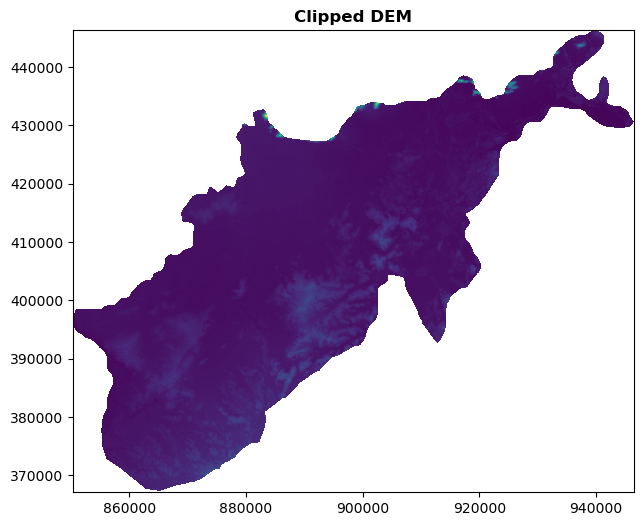

In [16]:
# # FOR AOI THAT IS WETLAND BOUNDARY

# from rasterio.plot import show
# from rasterio.mask import mask

# # Load your Area of Interest (AOI) as a GeoDataFrame
# aoi_path = '/home/jovyan/GuyanaFlooding/data/Rupununi_Wetlands_epsg32620.geojson'
# aoi = gpd.read_file(aoi_path)

# # Load the DEM raster file
# dem_path = '/home/jovyan/GuyanaFlooding/data/rupununiDEMprj.tif'
# with rasterio.open(dem_path) as src:
#     # Clip the raster with the polygon using mask
#     out_image, out_transform = mask(src, aoi.geometry, crop=True)
#     out_meta = src.meta.copy()

# # Update the metadata to reflect the number of layers
# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})

# # Save the clipped raster to disk
# clipped_output_path = '/home/jovyan/GuyanaFlooding/data/clipped_rupununiDEM.tif'
# with rasterio.open(clipped_output_path, "w", **out_meta) as dest:
#     dest.write(out_image)

# # Optionally, display the clipped image
# with rasterio.open(clipped_output_path) as clipped:
#     plt.figure(figsize=(10, 6))
#     show(clipped, title='Clipped DEM')
#     plt.show()


<font face="Calibri" size="5"> <b>3. Load Basins</b></font>
<br><br>
<font face="Calibri" size="3">Here we load the apropriate basin information.</font>

In [18]:
# ADDED BY ANDRE 
# Define the new directory for storing data
hybas_dir = Path('/home/jovyan/GuyanaFlooding/data')

# Create the directory if it does not exist
hybas_dir.mkdir(parents=True, exist_ok=True)

# Links dictionary for HydroBASINS data
hybas_links = {
    'sa': 'https://www.dropbox.com/sh/hmpwobbz9qixxpe/AABPzWxd07pmshjZl6Y0NPXNa/HydroBASINS/standard/sa/hybas_sa_lev12_v1c.zip?dl=1'
}

# Selecting the South America link
sa_link = hybas_links['sa']

# Define file paths for the zip and shape files
hybas_zipfile = hybas_dir / "hybas_sa_lev12_v1c.zip"
hybas_file = hybas_dir / "hybas_sa_lev12_v1c.shp"

# Download the zip file if it does not exist
if not hybas_zipfile.exists():
    urllib.request.urlretrieve(sa_link, hybas_zipfile)

# Extract the zip file if the shapefile does not exist
if not hybas_file.exists():
    with zipfile.ZipFile(hybas_zipfile, 'r') as zip_ref:
        zip_ref.extractall(path=hybas_dir)  # Extracts all files in the zip to the specified directory
    hybas_zipfile.unlink()  # Optionally remove the zip file after extraction

print(f"Downloaded and extracted: {hybas_file}")


Downloaded and extracted: /home/jovyan/GuyanaFlooding/data/hybas_sa_lev12_v1c.shp


In [ ]:
# temp_dir = temp_dir.expanduser()
# hybas_dir = hybas_dir.expanduser()
# gshhg_dir = gshhg_dir.expanduser()

# if not hybas_dir.exists():
#     hybas_dir.mkdir()
    
# if not gshhg_dir.exists():
#     gshhg_dir.mkdir()
    
# # extent_file=os.path.join(hybas_dir,'hybas_extent_v1c.gpkg')
# extent_file = hybas_dir/'hybas_extent_v1c.gpkg'

# if not extent_file.exists():
#     #!wget -O hybas_extent_v1c.gpkg https://www.dropbox.com/s/fthjqjnxj829d7p/hybas_extent_v1c.gpkg?dl=1
#     urllib.request.urlretrieve(hybas_extents_url, extent_file)    
    
# #find which hydrobasin data to download. 
# pf_dict={1:'af',2:'eu',3:'si',4:'as',5:'au',6:'sa',7:'na',8:'ar',9:'gr'} #PF=Pfafstetter Code, https://www.hydrosheds.org/images/inpages/HydroBASINS_TechDoc_v1c.pdf
# pf_desc={'af':'Africa', 'eu':'Europe', 'si':'Siberia', 'as':'Asia', 'au':'Australia', 'sa':'South America', 'na':'North America', 'ar':'Arctic', 'gr':'Greenland'}

# #read extent shapes
# shapes,pf_codes=fiona_read_vectorfile(extent_file, get_property='PF_CODE')

# #find intersecting shapes
# polygons=intersect(shapes, dem_poly_wgs84, properties=pf_codes)
# #Find the correct Pfafstetter code 
# if any(polygons):
#     if len(np.unique(polygons))==1: #polygons==[polygons[0]]:
#         pf_str=pf_dict[polygons[0]]
#         print(f'Detected hydrobasin location: {pf_desc[pf_str]}')
#     else:
#         print(f'The DEM is intersecting with {len(np.unique(polygons))} continents.')
#         print('Please select the continent you would like to process:')
#         print(pf_dict)        
#         pf_str=input()
# else: 
#     print("Can not find a compatible hydrobasins area for this DEM. If it's a small DEM, try regular HAND instead of Big HAND.")
#     assert False    

# hybas_zipfile = hybas_dir/f"hybas_{pf_str}_lev12_v1c.zip"
# hybas_file = hybas_dir/f"hybas_{pf_str}_lev12_v1c.shp"  

# if not hybas_zipfile.exists() and not hybas_file.exists():
#     #!wget -O {hybas_zipfile} {hybas_links[pf_str]}
#     urllib.request.urlretrieve(hybas_links[pf_str], hybas_zipfile)
# if not hybas_file.exists(): 
#     #!unzip -o {hybas_zipfile} # The HydroBASINS_TechDoc_v1c.pdf is common and requires overwriting.
#     with zipfile.ZipFile(hybas_zipfile, 'r') as zip_ref:          
#         zip_ref.extractall(path=hybas_dir) #overwrites HydroBASINS_TechDoc_v1c.pdf by default
#     hybas_zipfile.unlink()

<font face="Calibri" size="4"> <b>3.1 Match basins to DEM projection</b></font>
<br><br>
<font face="Calibri" size="3"> Use `reproject()` function to convert the hydrobasin file (`hybas_file`) to the same projection as the DEM if necessary.  

In [64]:
print(dem.crs)

EPSG:32620


In [19]:
hybas_gdf = gpd.read_file(hybas_file)
hybas_crs = hybas_gdf.crs
print(f"Hydrobasins CRS: {hybas_crs.to_string()}")

Hydrobasins CRS: EPSG:4326


In [20]:
# Load your Hydrobasins shapefile
hybas_file = '/home/jovyan/GuyanaFlooding/data/hybas_sa_lev12_v1c.shp'  # Replace with your actual path
gdf = gpd.read_file(hybas_file)

# Check if the CRS of the DEM is not 'EPSG:4326', and reproject if necessary
dem_crs = dem.crs  # This should be dynamically set based on your DEM's CRS

if gdf.crs.to_string() != dem_crs:
    print("DEM and Hydrobasins projections differ.")
    print("Reprojecting Hydrobasins shapefile.")

    # Define the output file path for the reprojected shapefile
    hybas_epsg = f"{hybas_file[:-4]}_epsg32620.shp"

    # Reproject and save the shapefile
    if not Path(hybas_epsg).exists():
        gdf = gdf.to_crs(dem_crs)
        gdf.to_file(hybas_epsg)
        print(f"Output File: {hybas_epsg}")
    else:
        print(f"File already exists: {hybas_epsg}")
else:
    print("No reprojection needed.")

hybas_file = hybas_epsg

DEM and Hydrobasins projections differ.
Reprojecting Hydrobasins shapefile.
File already exists: /home/jovyan/GuyanaFlooding/data/hybas_sa_lev12_v1c_epsg32620.shp


In [ ]:
# if dem.crs.to_string() != 'EPSG:4326':
#     print("DEM and Hydrobasins projections differ.")
#     print("Reprojecting Hydrobasins shapefile.")
#     hybas_epsg = f'{hybas_file}'[:-4]+'_epsg4326.shp'
    
#     if not Path(hybas_epsg).exists():
#         hybas_file = reproject(hybas_file, dem.crs, output_file=hybas_epsg)
#     else:
#         hybas_file = hybas_epsg
#     print(f"Output File: {hybas_file}")

<font face="Calibri" size="4"> <b>3.2 Read and Intersect HydroBasins</b></font>
<br><br>
<font face="Calibri" size="3">Read all polygons in the HydroBasins file and intersect with the DEM bounding box stored in `dem_poly`. 

In [21]:
#Find basins intersecting the DEM.
shapes,hybas_id=fiona_read_vectorfile(hybas_file, get_property='HYBAS_ID')
polygons=intersect(shapes, dem_poly)
polygon_ids=intersect(shapes, dem_poly, properties=hybas_id)
print(f"Number of polygons intersecting the DEM: {len(polygons)}")

Number of shapes loaded: 136157


  0%|          | 0/136157 [00:00<?, ?it/s]

  0%|          | 0/136157 [00:00<?, ?it/s]

Number of polygons intersecting the DEM: 90


<font face="Calibri" size="4"> <b>3.3 Calculate HAND</b></font>
<br><br>
<font face="Calibri" size="3">Loop over the intersecting `polygons` and calculate hand. We are using Python's assignment by reference to make place the hand values for a small area `h` in large `hand` array. 
    
Ref: https://docs.python.org/2.0/ref/assignment.html

In [24]:
#Loop over each basin and calculate HAND
# t=time.time()
if dem_nodata_value is None:
    dem_nodata_value=dem.nodatavals[0]
if dem_nodata_value is None:
    print('DEM does not have a defined no-data value.')
    print('Assuming all valid pixels. If not, expect long processing times.')
else:
    dem_nodata_mask=dem.read(1)==dem_nodata_value
    
hand=np.zeros(dem.shape)
hand[:]=np.nan #set the hand to nan to make sure untouched pixels remain that value and not zero, which is a valid HAND height.
for k,p in enumerate(tqdm(polygons)):
    verbose=False
    mask,tf,win = rasterio.mask.raster_geometry_mask(dem, [p], crop=True, pad=True, pad_width=pad_width) #add 1 pixel. calculate_hand needs it.  
    if win.width==1 or win.height==1: #padding may require this limit to change. 
        continue # The DEM is a thin line, skip this patch
    not_mask=np.bitwise_not(mask)
    #if polygon_ids[k] == 4120928640: #k=15 for polygon_ids, in hybas_id[70883]
    #    verbose=True
    if dem_nodata_mask[win.row_off:win.row_off+win.height,win.col_off:win.col_off+win.width].all():
        continue # do not process if the entire polygon is nodata
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        h=calculate_hand(np.squeeze(dem.read(window=win)), tf, pyproj.Proj(init=dem.crs.to_string()), mask=not_mask, verbose=verbose, acc_thresh=accumulation_threshold)
    clip_hand=hand[win.row_off:win.row_off+win.height,win.col_off:win.col_off+win.width] #By reference
    clip_hand[not_mask]=h[not_mask]
hand[dem_nodata_mask]=nodata_fill_value

  0%|          | 0/90 [00:00<?, ?it/s]

<font face="Calibri" size="4"> <b>3.4 Final Check for NaNs in HAND</b></font>
<br><br>
<font face="Calibri" size="3"> We check here again if there is any NaN values in HAND. This may be due to the fill_nan kernel being too small to fill all the NaNs, or alternatively if the basins do not cover the entire DEM due to errors in shapefile which may result in gaps.
<br><br>
<font face="Calibri" size="3"> Assuming we have a very large HAND that we can not fill-nan in one shot, we do this in smaller chunks. We find where the NaNs are, and separate non-touching NaNs into labelled objects using `ndimage.label()`. We then use this to loop over the HAND and fill NaNs over these small chunks. We again use assignment by reference to assign smaller nan-filled arrays into the large HAND array.
<br><br>
<font face="Calibri" size="3"> Finally, HAND can include NaNs due to coastal areas. We mask that using the Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG). 
    

In [25]:
# #Create a Land Mask so that we do not try to NAN-Fill over the Ocean. 
if np.any(np.isnan(hand)):
    print(f'{np.sum(np.isnan(hand))} NaN Pixels Detected in hand_result')
    #generate nan_mask
    #hand_type=hand.dtype
    #hand_orig=hand.copy()
    nan_mask=np.isnan(hand)
    # Download GSHHG    
    gshhg_zipfile = gshhg_dir/"gshhg-shp-2.3.7.zip"
    gshhg_file = gshhg_dir/"GSHHS_shp/f/GSHHS_f_L1.shp"
    if not gshhg_zipfile.exists() and not gshhg_file.exists():
        #!wget -O {gshhg_zipfile} http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip
        urllib.request.urlretrieve(gshhg_url, gshhg_zipfile)
    if not gshhg_file.exists(): 
        #!unzip {gshhg_zipfile}
        with zipfile.ZipFile(gshhg_zipfile, 'r') as zip_ref:          
            zip_ref.extractall(path=gshhg_dir)
    #if needed warp gshhg
    if dem.crs.to_string() != 'EPSG:4326':
        print("DEM and GSHHG projections differ.")
        #read extent shapes
        gshhg_df=gpd.read_file(gshhg_file)
        shapes=fiona_read_vectorfile(gshhg_file)
        #find intersecting shapes
        polygons=intersect(shapes, dem_poly_wgs84)              
        gshhg=[]
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            for p in polygons:
                pt=transform_polygon(p.exterior.coords, s_srs='epsg:4326', t_srs='epsg:'+str(dem.crs.to_epsg()))
                gshhg.append(point_coordinates_to_geometry(pt.exterior.coords))
    else:
        gshhg=fiona_read_vectorfile(gshhg_file)       
    #generate land_mask for the DEM
 
    land_mask,tf,win = rasterio.mask.raster_geometry_mask(dem, gshhg, crop=False, invert=True) #invert=If False (default), mask will be False inside shapes and True outside
    #find nan areas that are within land_mask
    # #set ocean/sea values in hand to epsilon
    if nodata_fill_value is not None:
        hand[np.invert(land_mask)]=nodata_fill_value #sea_mask=np.invert(land_mask)
    joint_mask=np.bitwise_and(nan_mask,land_mask)
    mask_labels, num_labels=ndimage.label(joint_mask)
    print(f"Number of NaN areas to fill: {num_labels}")
    

470769 NaN Pixels Detected in hand_result
DEM and GSHHG projections differ.
Number of shapes loaded: 179837


  0%|          | 0/179837 [00:00<?, ?it/s]

Number of NaN areas to fill: 43001


<font face="Calibri" size="4"> <b>3.4.1 Nan-Fill Loop</b></font>
<br><br>
<font face="Calibri" size="3"> For some larger DEMs the kernel can crash during the loop. Therefore we take a break here to export some files as backup and delete unused variables. 
    

In [26]:
#Run the NAN-fill operation.
try: #If ran multiple times these variables might not exist. Hence they are in a try/except block.
    del shapes, polygons, gshhg
    del land_mask, nan_mask
except:
    pass
print('Filling NaNs')

# #new nan_fill needs DEM. Might be better to NOT load it in the memory See: https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
demarray=dem.read(1)

if np.any(np.isnan(hand)):
    object_slices=ndimage.find_objects(mask_labels)    
    tq=tqdm(range(1,num_labels))
    for l in tq: #Skip first, largest label.        
        #ids = np.argwhere(mask_labels==l)
        #min0=max(ids[:,0].min()-1, 0)
        #max0=min(ids[:,0].max()+1, mask_labels.shape[0])
        #min1=max(ids[:,1].min()-1, 0)
        #max1=min(ids[:,1].max()+1, mask_labels.shape[1])        
        slices=object_slices[l-1] #osl label=1 is in object_slices[0]
        min0=max(slices[0].start-1,0) 
        max0=min(slices[0].stop+1, mask_labels.shape[0])
        min1=max(slices[1].start-1, 0)
        max1=min(slices[1].stop+1, mask_labels.shape[1])       
        mask_labels_clip=mask_labels[min0:max0, min1:max1]
        h=hand[min0:max0, min1:max1] #by reference
        d=demarray[min0:max0, min1:max1]
        m=joint_mask[min0:max0, min1:max1].copy()
        m[mask_labels_clip!=l]=0 #Maskout other flooded areas (labels) for this area. Use only one label.
        if np.size(m)>1e6:
            num_nan=m.sum()
            tq.set_description(f"Size: {num_nan}")
            if num_nan<1e6:
                #hf=fill_nan(h.copy()) #break reference
                hf=fill_nan_based_on_DEM(h.copy(), d.copy())
                h[m]=hf[m] #copy nanfill by reference
            else:
                print(f'Filling {num_nan} pixels')
                print('This can take a long time...')
                hf=fill_nan_based_on_DEM(h.copy(), d.copy()) #break reference
                h[m]=hf[m] #copy nanfill by reference
        else:
            hf=fill_nan_based_on_DEM(h.copy(), d.copy()) #break reference
            h[m]=hf[m] #copy nanfill by reference

Filling NaNs


  0%|          | 0/43000 [00:00<?, ?it/s]

<font face="Calibri" size="4"> <b><i>4. Export Raster </i></b></font>
<br><br>
<font face="Calibri" size="3">Output the HAND raster as a gdal generated geotiff. If a different format is preferred, can be provided to the gdal_write function. 

In [27]:
# Write HAND to a file. 
hand_file = Path(dem_file).parent/(f"{Path(dem_file).stem}_hand_{version.replace('.','_')}_clipped.tif")
gdal_write(hand, dem_gT, filename=str(hand_file), srs_proj4=dem_proj4, nodata=np.nan, data_format=gdal.GDT_Float32)
#cleaning up 
temporary_folder_object.cleanup()

File written to: /home/jovyan/GuyanaFlooding/data/clipped_rupununiDEM_hand_0_1_13_clipped.tif


<font face="Calibri" size="4"> <b><i>4.1 Display HAND</i></b></font>
<br><br>
<font face="Calibri" size="3">Display the HAND output using std.dev. based min,max for colobar. Holes (no-data, not-a-number,nan) appear as white. We will not go below 0 since height above nearest drainage should not be negative below zero. 

Setting colorbar limits as min:0 max:15


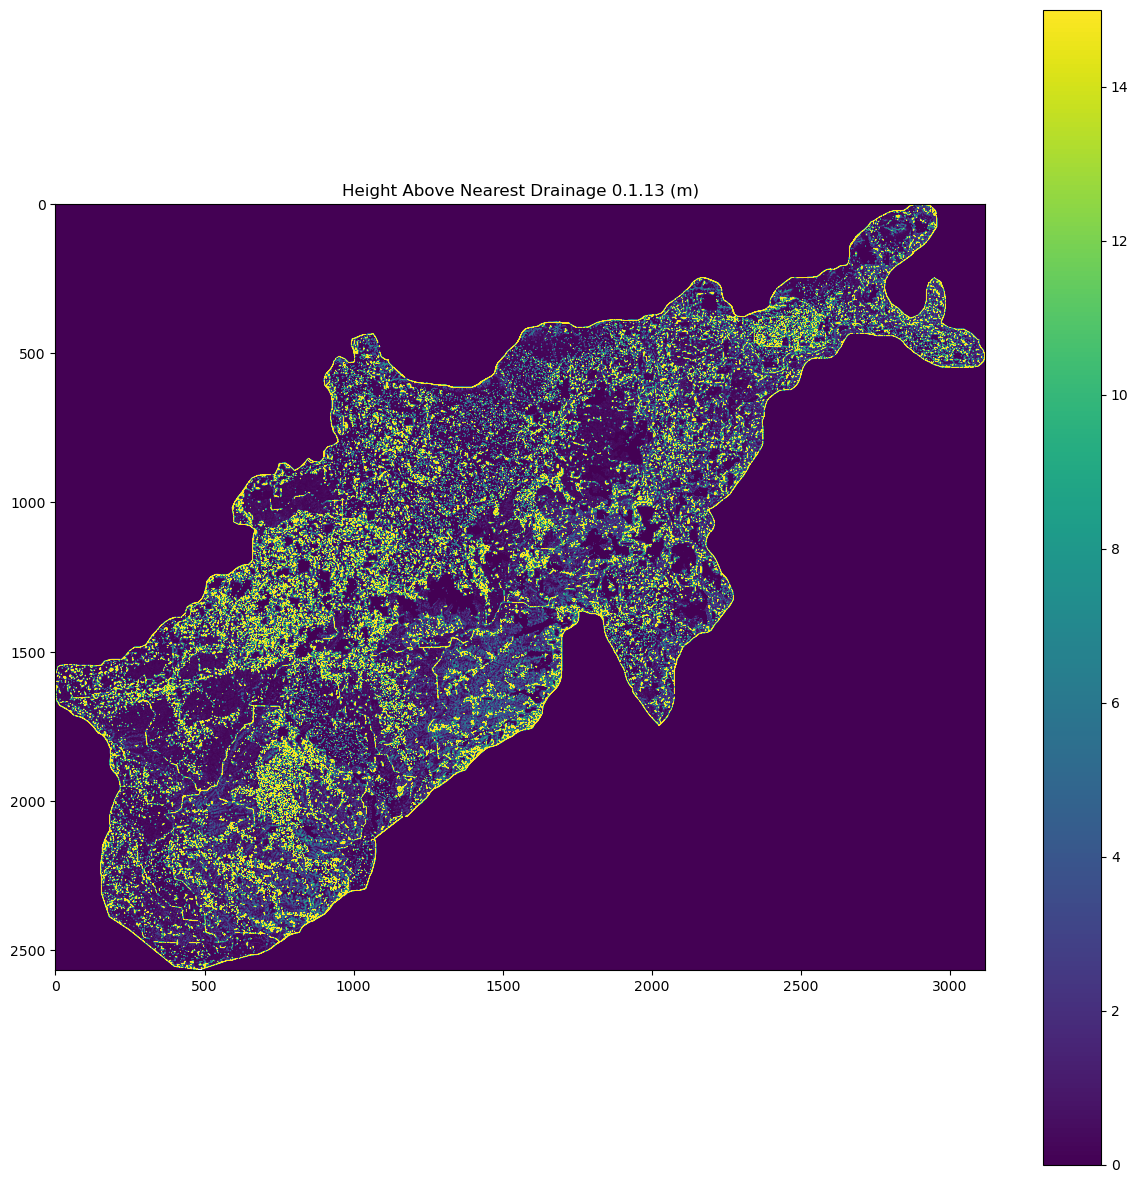

In [35]:
%matplotlib inline

#Show HAND if plotting is requested. 
if show_plots:
    #calculate mean and std.dev. for HAND
    m=np.nanmean(hand) 
    s=np.nanstd(hand)
    #minimum value should be no lower than 0. 
    hmin=max(m-2*s,0)
    #If there is a large variation, just show the first 15m. 
    hmax=min(m+2.5*s,15)
    plt.figure(figsize=(15,15))
    print(f"Setting colorbar limits as min:{hmin} max:{hmax}")
    plt.imshow(hand)
    plt.colorbar()
    plt.clim([hmin,hmax])
    plt.title(f'Height Above Nearest Drainage {version} (m)')

Setting colorbar limits as min: 0 max: 15


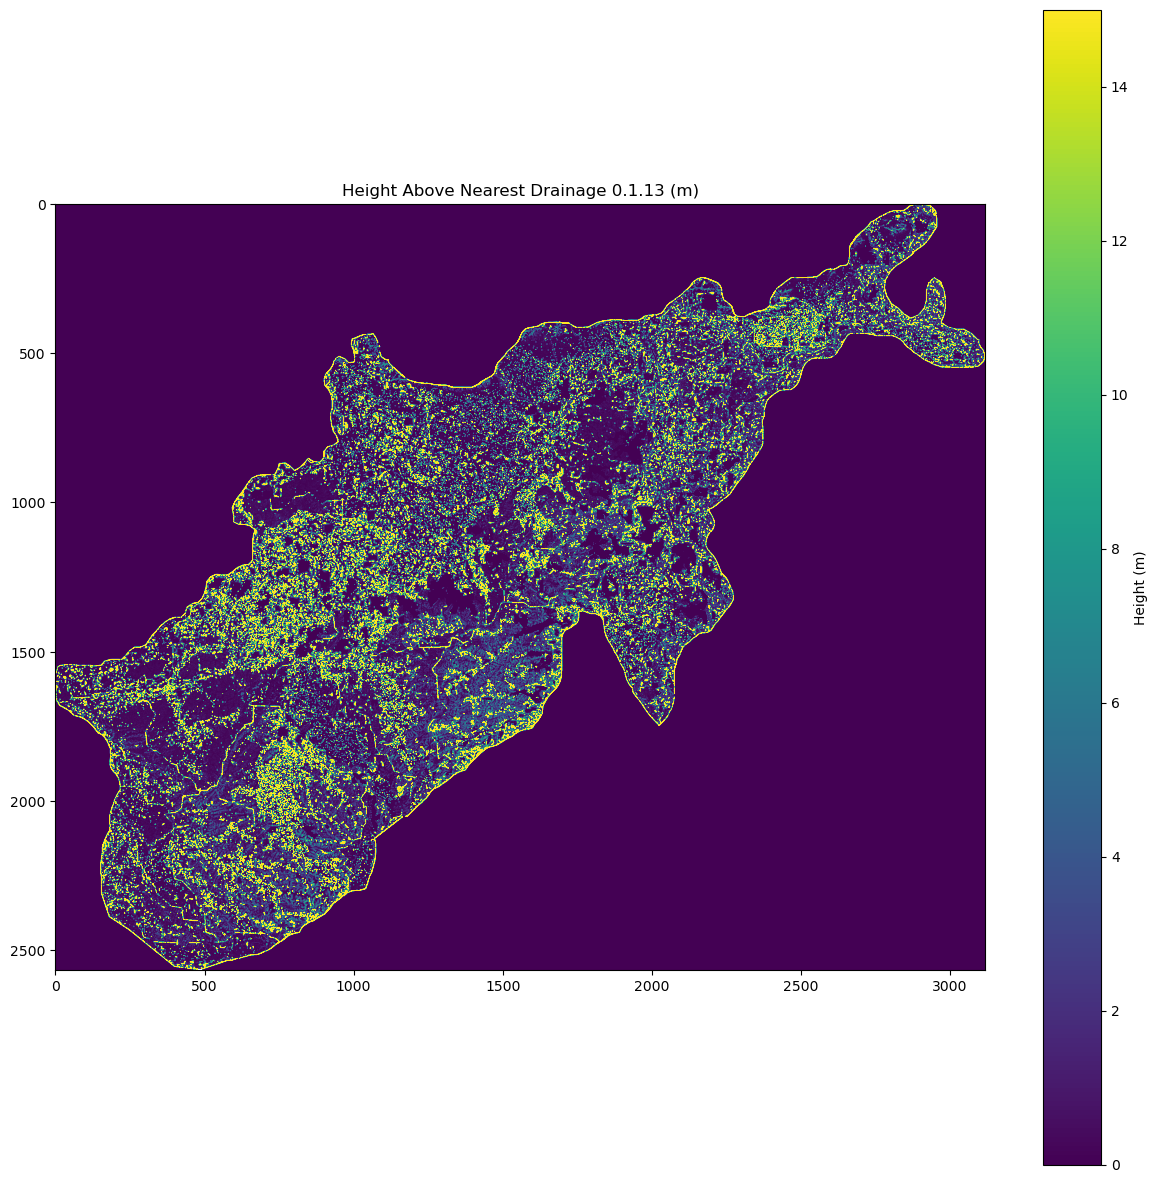

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path to the HAND raster
hand_path = '/home/jovyan/GuyanaFlooding/data/HAND_rupununi_clipped.tif'

# Open the raster file using rasterio
with rasterio.open(hand_path) as src:
    # Read the first band (assuming HAND data is in the first band)
    hand = src.read(1)

# Assuming 'show_plots' is True, adjust as necessary
show_plots = True
version = "0.1.13"  # Adjust the version number as necessary

if show_plots:
    # Calculate mean and standard deviation, ignoring NaN values
    m = np.nanmean(hand)
    s = np.nanstd(hand)

    # Minimum value should be no lower than 0
    hmin = max(m - 2 * s, 0)

    # If there is a large variation, just show the first 15m
    hmax = min(m + 2.5 * s, 15)

    # Create a figure with a specific size
    plt.figure(figsize=(15, 15))
    print(f"Setting colorbar limits as min: {hmin} max: {hmax}")

    # Display the HAND data as an image
    img = plt.imshow(hand, cmap='viridis', vmin=hmin, vmax=hmax)  # Using 'viridis' colormap, adjust as needed

    # Add a colorbar to the plot
    plt.colorbar(img, label='Height (m)')

    # Set color limits for the colormap
    img.set_clim(hmin, hmax)

    # Add a title to the plot
    plt.title(f'Height Above Nearest Drainage {version} (m)')

    # Show the plot
    plt.show()


Setting colorbar limits as min: 0 max: 15


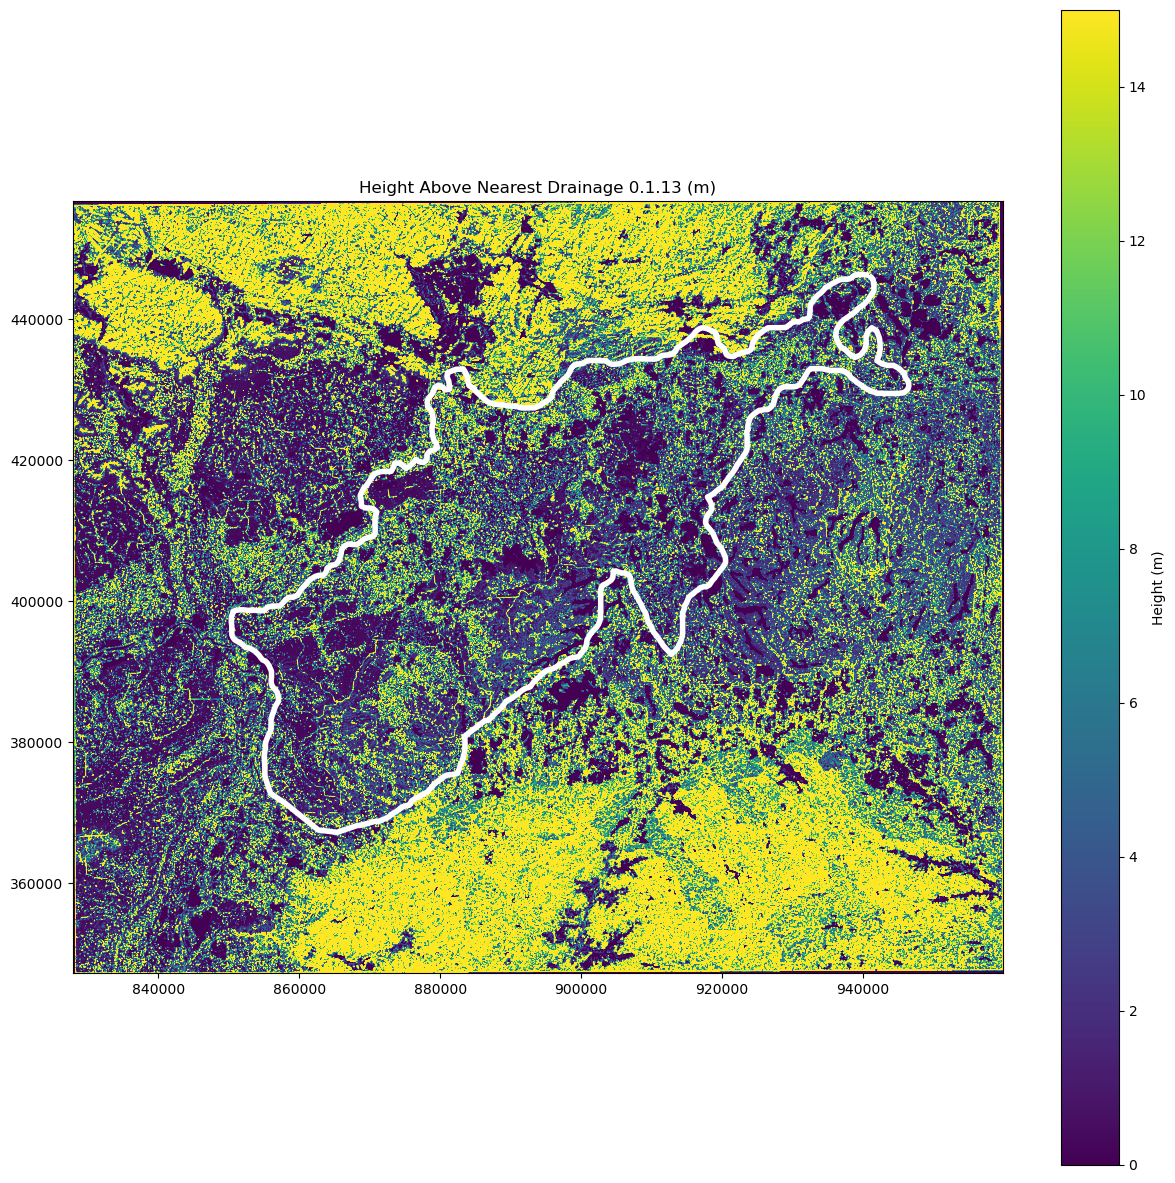

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# File path to the HAND raster
hand_path = '/home/jovyan/GuyanaFlooding/data/HAND_rupununi.tif'

# File path to the GeoJSON
aoi_path = '/home/jovyan/GuyanaFlooding/data/Rupununi_Wetlands_epsg32620.geojson'

# Load your Area of Interest (AOI) as a GeoDataFrame
aoi = gpd.read_file(aoi_path)

# Open the raster file using rasterio
with rasterio.open(hand_path) as src:
    # Read the first band (assuming HAND data is in the first band)
    hand = src.read(1)
    # Capture the affine transform and CRS
    transform = src.transform
    crs = src.crs

# Assuming 'show_plots' is True, adjust as necessary
show_plots = True
version = "0.1.13"  # Adjust the version number as necessary

if show_plots:
    # Calculate mean and standard deviation, ignoring NaN values
    m = np.nanmean(hand)
    s = np.nanstd(hand)

    # Minimum value should be no lower than 0
    hmin = max(m - 2 * s, 0)

    # If there is a large variation, just show the first 15m
    hmax = min(m + 2.5 * s, 15)

    # Create a figure with a specific size
    fig, ax = plt.subplots(figsize=(15, 15))
    print(f"Setting colorbar limits as min: {hmin} max: {hmax}")

    # Display the HAND data as an image
    img = ax.imshow(hand, cmap='viridis', vmin=hmin, vmax=hmax, extent=rasterio.plot.plotting_extent(src))  # Using 'viridis' colormap, adjust as needed

    # Overlay the GeoJSON with transparent fill and white outline
    aoi.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

    # Add a colorbar to the plot
    cbar = fig.colorbar(img, ax=ax, label='Height (m)')

    # Add a title to the plot
    ax.set_title(f'Height Above Nearest Drainage {version} (m)')

    # Show the plot
    plt.show()



<font face="Calibri" size="2" color="gray"> <i> Contacts: Batu Osmanoglu, MinJeong Jo
    
<b>Change Log</b> <br>
2022/05/23: v0.1.14<br>
-BugFix: Fix broken plot at end of notebook
2022/02/25: v0.1.13<br>
-BugFix: Updating code to work with latest pysheds. <br>
2021/08/18: v0.1.12<br>
-BugFix: Improved interpolation with interpolating the DEM-HAND instead of HAND directly. We are referring to this as Height of Nearest Drainage (HOND=DEM-HAND). <br>
2021/03/30: v0.1.11<br>
-Feat: Implemented DEM nodata mask, to avoid calculation of HAND when the DEM has nodata values. These values are filled with nodata_fill_value (renamed ocean_fill_value).  <br>   
2021/03/29: v0.1.10<br>
-BugFix: Franz Meyer and batu adding ocean_fill_value to avoid long nan-fill operation in HYDRO30Workflow-v1. <br>
2021/01/27: v0.1.9 <br>  
-BugFix: Franz Meyer (UAF) reported an issue stating fiona_write_vectorfile() is failing in section 3.4 by giving a `fiona.errors.CRSError`. Implemented a workaround to avoid the function.<br> 
    2021/01/20: v0.1.8 <br>
-Feat: Added zero-fill for low-lying nan areas in the HAND. These are often drainage areas with vegetation (or levees) around, denying any water from the basin to drain, despite being the lowest region in DEM. <br>
2021/01/14: v0.1.7 <br>    
-BugFix: Improved nan-handling for HAND calculation resolve_flats step. <br>
-Feat: Added automatic accumulation threshold calculation. <br>
2021/01/07: v0.1.6 <br>
-Feat: Folder cleanup is added.<br>
-Feat: Using zipfile and urllib instead of unzip and wget system calls. <br>
2020/11/16: v0.1.5  <br>
-BugFix: The EU HydroBasins link was set to AR<br>
2020/10/16: 0.1.4 <br>
-BugFix: Output was not respecting requested format, and was defaulting to 64bit. Also changed gdal_write() to generate Cloud-Optimized-Geotiff by default.  <br>
-Feat: Performance upgrade to nan-filling. <br>
2020/09/17: <br>
-BugFix: Evan Smith (BYU) reported an issue which was resulting from the basin mapping to a 1pixel-wide DEM. Modified code to skip single pixel wide or high DEM patches. <br>
2020/07/21: <br>
-BugFix: Certain DEM projections was causing Inf values when global datasets were reprojected. Added a clipping step before projecting global datasets to DEM projection. <br>
2020/06/02: <br>
-BugFix: Added individual HydroBasin links for each region. <br>
-BugFix: Clearing no-longer used variables before final nan-fill loop. Also skipping nan-fill if region is bigger than 1 Million pixels. <br>
-BugFix: Moved export before display to make sure Hand is saved before attempting anything else when result is ready.<br>